# Mini Project

# Contents
- [Libraries loading](#Libraries-loading)
- [Loading and cleaning data](#Loading-and-cleaning-data)
- [Visualization and analysis](#Visualization-and-analysis)
- [Problem statement](#Problem-statement)
- [Modeling](#Modeling)
- [Using the Tensorflow framework](#Using-the-Tensorflow-framework)
- [Best solutions](#Best-solutions)
- [References](#References)

# Libraries loading
[top](#Contents)

In [1]:
# ! pip install pandas numpy matplotlib sklearn tensorflow

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [3]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, multilabel_confusion_matrix, ConfusionMatrixDisplay, accuracy_score, RocCurveDisplay
from sklearn.preprocessing import MinMaxScaler

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier

In [39]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense

# Loading and cleaning data
[top](#Contents)

Reading data from a file and determining the size of the data. The protocol id is used as an index in the table.

In [5]:
data = pd.read_csv('data.csv', index_col='id')
print(f"Number of rows: {data.shape[0]}\nNumber of columns: {data.shape[1]}")
data.head(5)

Number of rows: 10811
Number of columns: 5


,color,flex,length,tensity,N
id,,,,,
42,NaN,NaN,NaN,NaN,NaN
43,NaN,NaN,NaN,NaN,NaN
44,NaN,NaN,NaN,NaN,NaN
47,4.0,40.0,60.0,168.0,11.0
52,3.0,41.0,62.0,233.0,11.0


All lines containing missing data are removed.

In [6]:
data = data.dropna(how='any').astype(int)
print(f"Number of rows: {data.shape[0]}\nNumber of columns: {data.shape[1]}")
data.head(5)

Number of rows: 10652
Number of columns: 5


,color,flex,length,tensity,N
id,,,,,
47,4,40,60,168,11
52,3,41,62,233,11
53,4,46,65,241,12
54,4,41,62,257,12
57,3,38,64,216,11


### Description of the data in the table

The table shows the results of more than 10,000 laboratory studies of the physical and mechanical properties of long scutched flax fiber. In the Republic of Belarus, long ragged flax fiber is produced by a large number of agricultural enterprises. After that, the fiber goes to the only one in Belarus and the largest flax processing enterprise in Europe - the Orsha Linen Mill. Selectively batches of flax fiber are tested for physical and mechanical properties using special laboratory equipment and industry standards. The main physical and mechanical properties to be tested are $color$, $length$, $flexibility$ and breaking load $tensity$. After processing the long scutched flax fiber into carded sliver on flax machines, the quality of the original long scutched flax fiber is determined using special standards. The quality of long scutched flax fiber is determined using an integer quality indicator ($N$). The table shows the production quality control data for the last few years.

# Visualization and analysis
[top](#Contents)

Flexibility, Length and Tensity of the flax fibers are continuous quantities. 

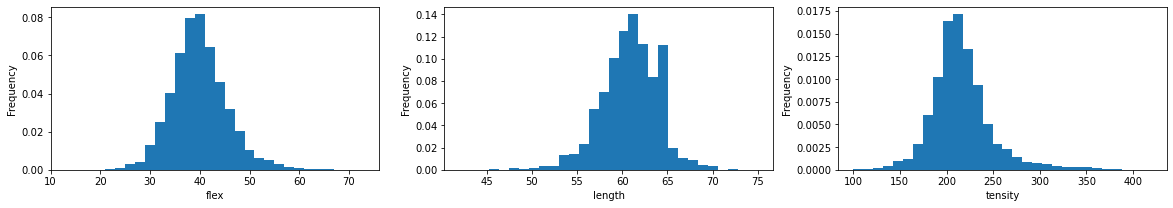

In [7]:
plt.figure(figsize=(20, 3))
for i, col in enumerate(['flex', 'length', 'tensity']):
    plt.subplot(1,3,i+1)
    data[col].plot.hist(grid=False, density=True, bins=30)
    plt.xlabel(col)
plt.show()

The color group and the quality index and are discrete values.

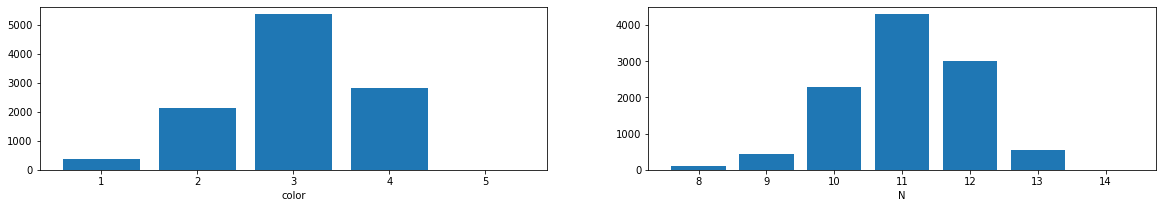

In [8]:
plt.figure(figsize=(20, 3))
for i, col in enumerate(['color', 'N']):
    plt.subplot(1,2,i+1)
    plt.bar(*np.unique(data[col], return_counts=True))
    plt.xlabel(col)
plt.show()

We visualize the linear trends on a scatterplot showing the change in the average value of a parameter with an increase in the quality indicator (N).

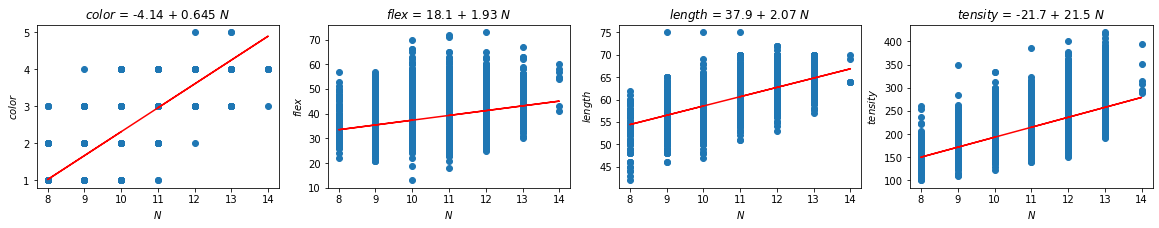

In [9]:
plt.figure(figsize=(20, 3))
for i, col in enumerate(data.columns[data.columns != 'N']):
    plt.subplot(1,4,i+1)
    plt.scatter(data['N'], data[col])
    coefs = np.polyfit(data['N'], data[col], 1) 
    # print(coefs)
    plt.plot(data['N'], np.poly1d(coefs)(data['N']), color="red")
    plt.xlabel('$N$')
    plt.ylabel(f'${col}$')
    plt.title(f'${col}$ = {coefs[1]:.3} + {coefs[0]:.3} $N$')
plt.show()

We visualize the tightness of the pair correlation between the quality index (N) and the rest of the physical and mechanical parameters of flax fiber using correlation matrix.

In [10]:
data.corr().style.background_gradient(cmap='coolwarm', axis=None).format(precision=2)

,color,flex,length,tensity,N
color,1.00,0.24,0.38,0.34,0.81
flex,0.24,1.00,-0.08,0.16,0.33
length,0.38,-0.08,1.00,0.33,0.64
tensity,0.34,0.16,0.33,1.00,0.62
N,0.81,0.33,0.64,0.62,1.00


Descriptive statistics of physical and mechanical properties.

In [11]:
data.describe().loc[:].round(2)

,color,flex,length,tensity,N
count,10652.00,10652.00,10652.00,10652.00,10652.00
mean,3.00,39.41,60.76,215.94,11.06
std,0.78,5.63,3.15,33.51,0.97
min,1.00,13.00,42.00,100.00,8.00
25%,3.00,36.00,59.00,197.00,10.00
50%,3.00,39.00,61.00,212.00,11.00
75%,4.00,43.00,63.00,229.00,12.00
max,5.00,73.00,75.00,420.00,14.00


Box plots for each of the parameters.

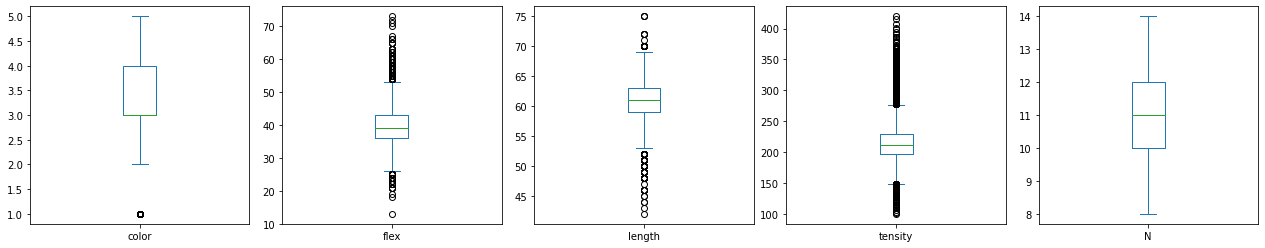

In [12]:
data.plot(kind='box', subplots=True, sharey=False, figsize=(22, 4))
plt.subplots_adjust(wspace=0.15) 
plt.show()

We visualize the box diagrams showing the change in the average value of a parameter with an increase in the quality indicator (N).

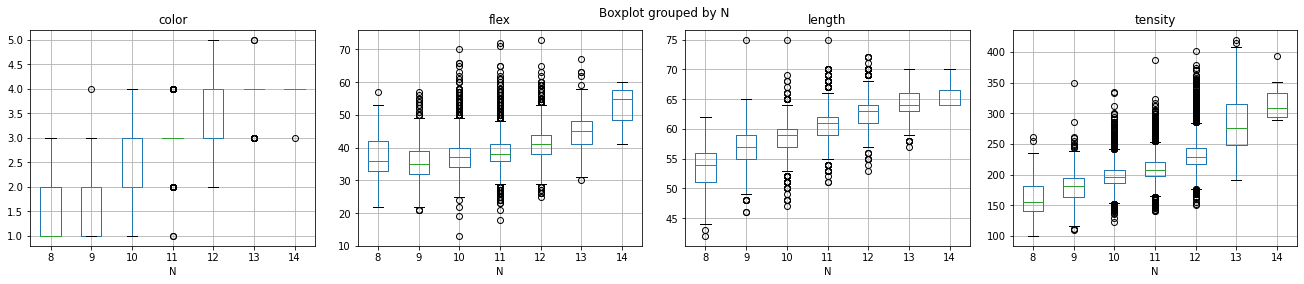

In [13]:
fig, ax = plt.subplots(1, data.shape[1]-1, figsize=(22, 4))
for i, col in enumerate(data.columns[data.columns != 'N']):
    data.boxplot(column=col, by='N', ax=ax[i])
plt.subplots_adjust(wspace=0.15) 
plt.show()

# Problem statement
[top](#Contents)

Manufacturers of long scutched flax fiber during the delivery of a batch to the plant declare what specific quality indicator the delivered batch corresponds to. It is possible to accurately determine the quality indicator only after processing it on flax machines, which takes time. At the same time, the physical and mechanical properties of a batch of flax fiber are known before its processing. Thus, it is advisable to develop a method that allows assessing, based on the physical and mechanical properties of a long trepanned fiber, whether it corresponds to the declared quality index ($N$), for example, $12$ or not.

# Modeling
[top](#Contents)

## Data preparation

The input data for the model are the physical and mechanical properties of a long scutched flax fiber. The independent variable takes the value $1$ if the quality index is greater than or equal to $12$, otherwise it is equal to $0$.

In [14]:
X = data[data.columns[data.columns != 'N']]
y = (data['N'].values >= 12).astype(int)

X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.6, random_state=123)

A helper function that allows us to evaluate the quality of a model.

In [15]:
def check_accuracy(model, X_test, y_test, title=''):
    y_pred = model.predict(X_test)
    print(f'Test score : {accuracy_score(y_test, y_pred)}')
    fig, ax = plt.subplots(1, 2, figsize=(15, 5))
    ConfusionMatrixDisplay(confusion_matrix(y_test, y_pred)).plot(ax=ax[0])    
    RocCurveDisplay.from_predictions(y_test, y_pred, ax=ax[1])
    plt.suptitle(title)
    plt.show()

The property visualization is divided by compliance with a quality score of 12.

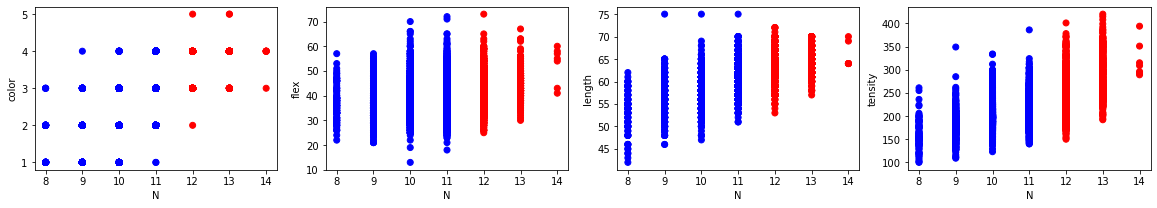

In [16]:
plt.figure(figsize=(20, 3))

for i, col in enumerate(data.columns[data.columns != 'N']):
    plt.subplot(1,4,i+1)
    plt.scatter(data['N'], data[col], c=['red' if c else 'blue' for c in y])
    plt.ylabel(col)
    plt.xlabel('N')
plt.show()

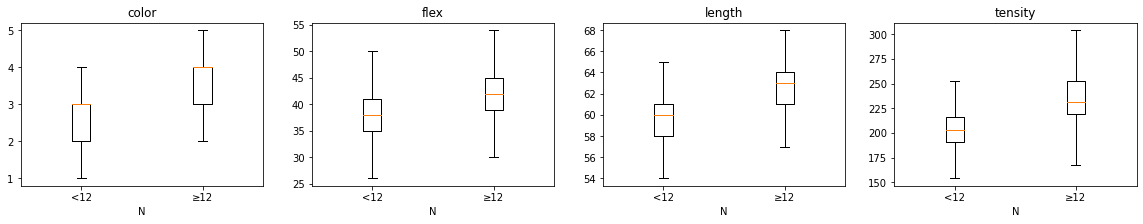

In [17]:
plt.figure(figsize=(20, 3))

for i, col in enumerate(data.columns[data.columns != 'N']):
    plt.subplot(1,4,i+1)
    box = plt.boxplot([data[col][y==0], data[col][y==1]], showfliers=False)
    plt.xticks([1, 2],['<12', '≥12'])
    plt.title(col)
    plt.xlabel('N')
plt.show()

## Logistic regression

Test score : 0.9823984980051631


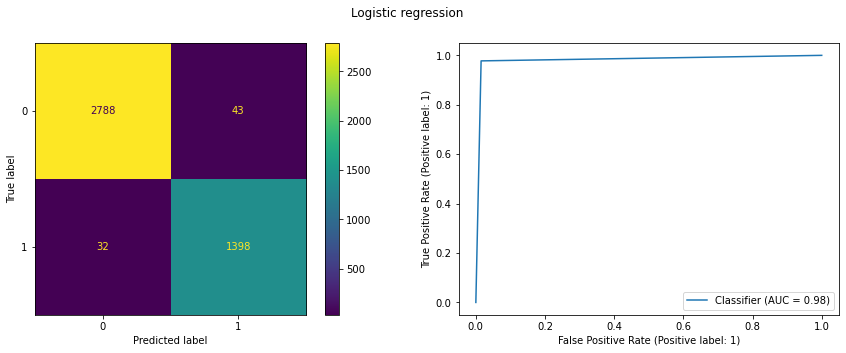

CPU times: user 592 ms, sys: 1.22 s, total: 1.81 s
Wall time: 426 ms


In [18]:
%%time
model_LogReg = LogisticRegression().fit(X_train, y_train)
check_accuracy(model_LogReg, X_test, y_test, 'Logistic regression')

As we can see, in more than $98,2$% of cases, the resulting model on the test dataset gives the correct results.

## Support Vector Machine

In [19]:
{kernel:SVC(kernel=kernel).fit(X_train, y_train).score(X_test, y_test) for kernel in ['linear', 'poly', 'rbf', 'sigmoid']}

{'linear': 0.98380661816475,
 'poly': 0.9047172025346163,
 'rbf': 0.8582492372682469,
 'sigmoid': 0.3703356019713682}

We see that better results are obtained using a linear kernel.

### Linear kernel

Test score : 0.98380661816475


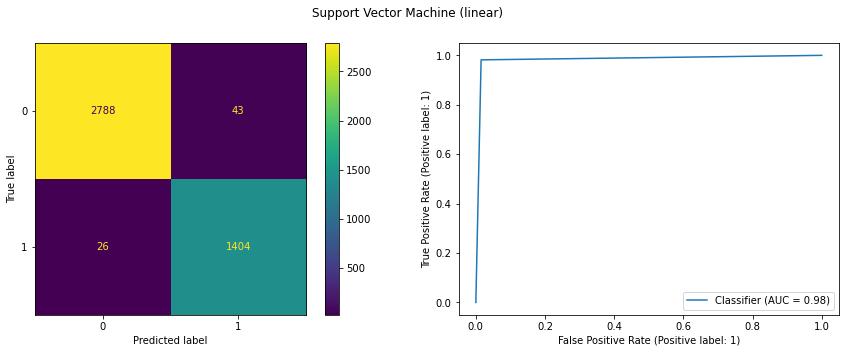

In [20]:
model_SVC_linear = SVC(kernel='linear').fit(X_train, y_train)
check_accuracy(model_SVC_linear, X_test, y_test, 'Support Vector Machine (linear)')

As we can see, in more than $98,3$% of cases, the resulting model on the test dataset gives the correct results.

### Poly kernel

Test score : 0.9047172025346163


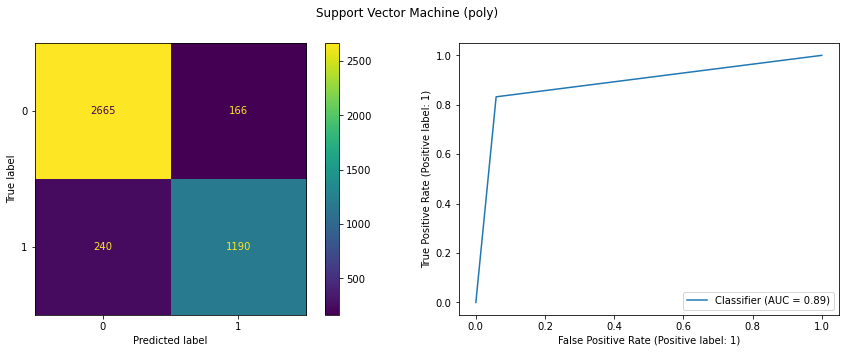

In [21]:
model_SVC = SVC(kernel='poly').fit(X_train, y_train)
check_accuracy(model_SVC, X_test, y_test, 'Support Vector Machine (poly)')

### Rbf kernel

Test score : 0.8582492372682469


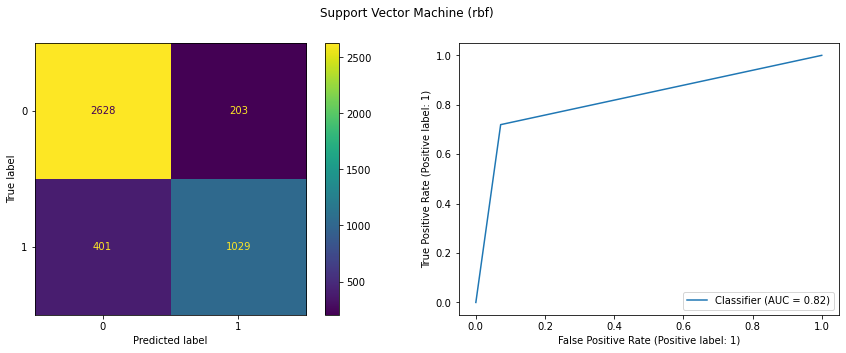

In [22]:
model_SVC = SVC(kernel='rbf').fit(X_train, y_train)
check_accuracy(model_SVC, X_test, y_test, 'Support Vector Machine (rbf)')

### Sigmoid kernel

Test score : 0.3703356019713682


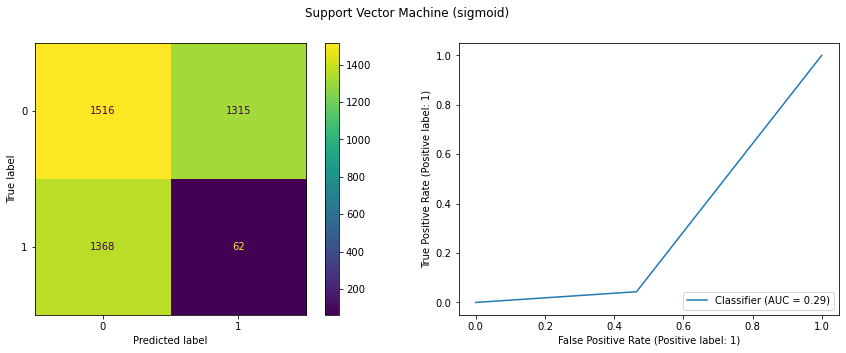

In [23]:
model_SVC = SVC(kernel='sigmoid').fit(X_train, y_train)
check_accuracy(model_SVC, X_test, y_test, 'Support Vector Machine (sigmoid)')

## Decision tree

Test score : 0.927951185167801


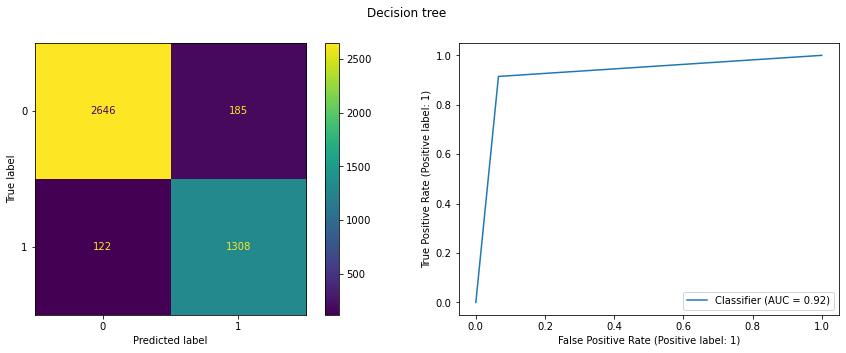

CPU times: user 277 ms, sys: 205 ms, total: 482 ms
Wall time: 225 ms


In [24]:
%%time
model_DT = DecisionTreeClassifier(max_depth=3, criterion="gini").fit(X_train,y_train)
check_accuracy(model_DT, X_test, y_test, 'Decision tree')

## Naive Bayes

Test score : 0.9554095282797466


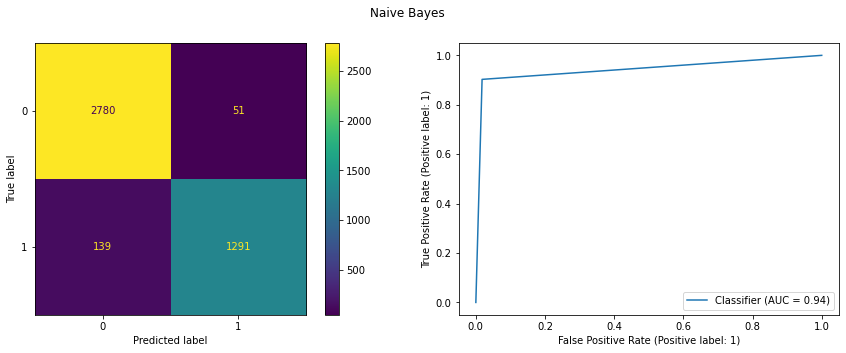

CPU times: user 248 ms, sys: 231 ms, total: 479 ms
Wall time: 222 ms


In [25]:
%%time
model_NB = GaussianNB().fit(X_train,y_train)

check_accuracy(model_NB, X_test, y_test, 'Naive Bayes')

## K-Nearest Neighbour

Test score : 0.9173902839708988


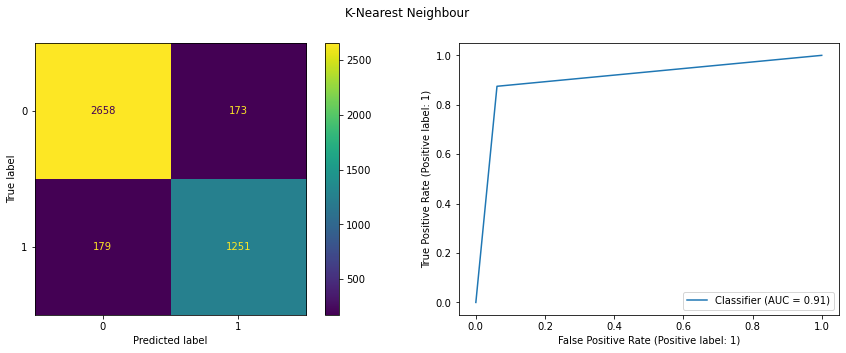

In [26]:
model_KNN = KNeighborsClassifier(n_neighbors=3).fit(X_train,y_train)

check_accuracy(model_KNN, X_test, y_test, 'K-Nearest Neighbour')

## Multi-layer perceptron

Test score : 0.9845106782445435


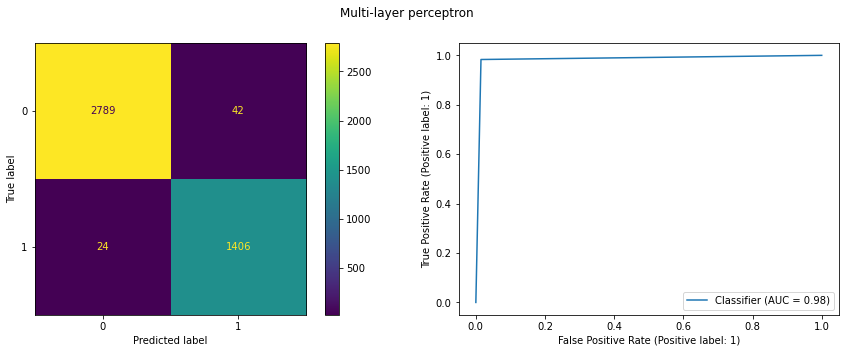

In [27]:
scalerMLP = MinMaxScaler()
X_train_scaled = scalerMLP.fit_transform(X_train)
X_test_scaled = scalerMLP.transform(X_test)

model_MLP = MLPClassifier(hidden_layer_sizes = (50,20), solver='lbfgs', activation='relu', random_state=123).fit(X_train_scaled, y_train)

check_accuracy(model_MLP, X_test_scaled, y_test, 'Multi-layer perceptron')

As we can see, in more than $98,4$% of cases, the resulting model on the test dataset gives the correct results.

# Using the Tensorflow framework
[top](#Contents)

## Deep Learning Classification model with Keras

Data preparation

In [28]:
X = data[data.columns[data.columns != 'N']]
y_dum = pd.get_dummies(data['N'])

X_train, X_test, y_train, y_test = train_test_split(X, y_dum, train_size=0.6, random_state=123)

scaler_Keras = MinMaxScaler()
X_train_scaled = scaler_Keras.fit_transform(X_train)
X_test_scaled = scaler_Keras.transform(X_test)

Create and compile model with 3 layers:

In [40]:
# Create a Sequential model
model_Keras = Sequential()
# Create a first hidden layer, the input for the first hidden layer is input layer which has 4 variables:
model_Keras.add(Dense(50, activation='relu', input_shape=(4,)))
# Create a second hidden layer
model_Keras.add(Dense(20, activation='relu'))
# Create an output layer with only 7 variables:
model_Keras.add(Dense(len(y_dum.columns),activation='softmax'))

model_Keras.compile(optimizer='adam', loss='categorical_crossentropy', metrics='accuracy')

Fit model

In [30]:
model_Keras.fit(X_train_scaled, y_train, epochs=100, verbose=1, validation_data=(X_test_scaled,y_test))

Epoch 1/100
200/200 [==============================] - 1s 3ms/step - loss: 1.4698 - accuracy: 0.3844 - val_loss: 1.2344 - val_accuracy: 0.5914
Epoch 2/100
200/200 [==============================] - 0s 2ms/step - loss: 1.1051 - accuracy: 0.6440 - val_loss: 0.9808 - val_accuracy: 0.6998
Epoch 3/100
200/200 [==============================] - 0s 2ms/step - loss: 0.8940 - accuracy: 0.7055 - val_loss: 0.8044 - val_accuracy: 0.7146
Epoch 4/100
200/200 [==============================] - 0s 2ms/step - loss: 0.7267 - accuracy: 0.7270 - val_loss: 0.6530 - val_accuracy: 0.7418
Epoch 5/100
200/200 [==============================] - 0s 2ms/step - loss: 0.5913 - accuracy: 0.7603 - val_loss: 0.5330 - val_accuracy: 0.7862
Epoch 6/100
200/200 [==============================] - 0s 2ms/step - loss: 0.4866 - accuracy: 0.8136 - val_loss: 0.4543 - val_accuracy: 0.8402
Epoch 7/100
200/200 [==============================] - 0s 2ms/step - loss: 0.4136 - accuracy: 0.8521 - val_loss: 0.3919 - val_accuracy: 0.8660

Evaluate model

In [31]:
results = model_Keras.evaluate(X_test_scaled, y_test, verbose=1)
print("test loss, test acc:", results)

134/134 [==============================] - 0s 906us/step - loss: 0.1672 - accuracy: 0.9427
test loss, test acc: [0.1672055721282959, 0.9427364468574524]


Evaluate accuracy

134/134 [==============================] - 0s 724us/step


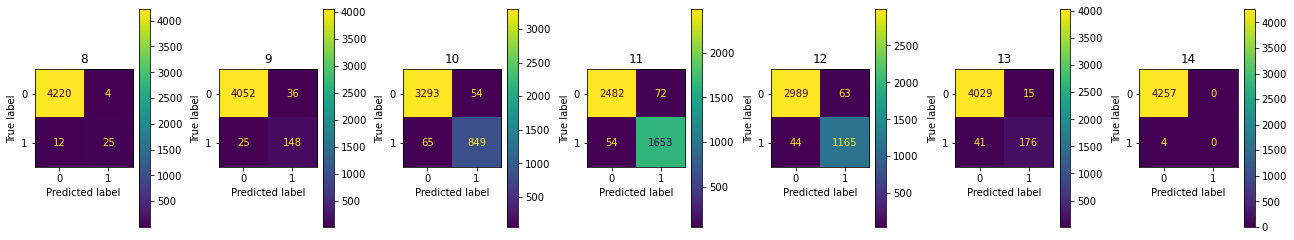

In [32]:
y_pred = (model_Keras.predict(X_test_scaled) > 0.5).astype(int)

fig, ax = plt.subplots(1, len(y_dum.columns), figsize=(22, 4))
for i, m in enumerate(multilabel_confusion_matrix(y_test, y_pred)):
    ConfusionMatrixDisplay(m).plot(ax=ax[i])
    ax[i].title.set_text(y_dum.columns[i])    
plt.subplots_adjust(wspace=0.5) 
plt.show()

In [33]:
accuracy_score(y_pred, y_test)

0.9425017601501995

As we can see, in more than $94,3$% of cases, the Keras model on the test dataset gives the correct results.

# Best solutions
[top](#Contents)

The best in terms of accuracy are the models of: multi-layer perceptron ($0.9845106782445435$), support vector machine ($0.98380661816475$) and logistic regression ($0.9823984980051631$). In order to use the obtained models, we describe a data set representing the physical and mechanical properties of two batches of flax fiber.

In [34]:
sample = pd.DataFrame({'color':[4, 2], 'flex':[42, 30], 'length':[60, 50], 'tensity':[215, 200]})
sample

,color,flex,length,tensity
0,4,42,60,215
1,2,30,50,200


## Multi-layer perceptron

In [35]:
model_MLP.predict(scalerMLP.transform(sample)).astype(bool)

array([ True, False])

## Support Vector Machine

In [36]:
model_SVC_linear.predict(sample).astype(bool)

array([ True, False])

## Logistic Regression

In [37]:
model_LogReg.predict(sample).astype(bool)

array([ True, False])

As we can see, all three models rated the first dataset as meeting a quality indicator of $12$ or higher, and the second set as not meeting the specified quality score.

## Deep Learning Classification model with Keras

A neural network model built using the Keras framework makes it possible to estimate what quality indicator can be assigned to a selected batch of fiber based on the values of its physical and mechanical properties.

In [38]:
pred = model_Keras.predict(scaler_Keras.transform(sample))

y_dum.columns[pd.DataFrame(pred).idxmax(axis=1).values]

1/1 [==============================] - 0s 17ms/step


Int64Index([12, 9], dtype='int64')

As you can see, the results of the evaluation using the neural network model are consistent with the results obtained using other models. In this case, the first batch of fibers is assigned to the $12$ quality indicator, and the second batch - to the $8$ quality indicator.

# References
[top](#Contents)

* https://clemsonciti.github.io/Workshop-Python-ML/15-Mini-Project/index.html

* Dyagilev, A. Investigation of belarussian long scutched flax fiber quality characteristics of 2013-th year crop / Dyagilev Andrey, Biziuk Andrei, Kogan Alexander // Vestnik of Vitebsk State Technological University. ─ 2014. ─ № 27. ─ p. 31. https://vestnik.vstu.by/files/3914/2624/3540/Investigation__belarussian_long_scutched_flax_fiber_quality_characteristics__2013-th_year_crop.pdf

* Dyagilev, A Comparative analysis of physical and mechanical properties of long scutched flax fiber / Dyagilev Andrey, Biziuk Andrei, Kogan Alexander // Vestnik of Vitebsk State Technological University. ─ 2016. ─ № 1(30). ─ p. 12. https://vestnik.vstu.by/files/8714/6651/6655/1-2.pdf

* GOST 10330-76 Scutched flax fi bre. Technical specification. https://meganorm.ru/Data/337/33790.pdf